In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:52<00:00, 24.9MB/s]
100% 1.06G/1.06G [00:52<00:00, 21.9MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [27]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.applications.vgg16 import VGG16

In [28]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False, # False -> not importing weights and bias for last convolutional layer (not freeze last conv layer)
    input_shape = (150, 150, 3)
)

In [29]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [32]:
conv_base.trainable = False

In [33]:
# generators -> very useful for large amount of data
train_ds = keras.utils.image_dataset_from_directory(
    directory = '//content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150,150)
)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


We stored the file numpy array and value is (0 - 255) but we have to store value (0 - 1). So, we use normalize.

### **Why using normalize?**
pixel value lie between 0 to 1 -> good accuracy


In [34]:
# normalize
def process(image, label):
  image = tf.cast(image/255. ,tf.float32)
  return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [35]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [36]:
history = model.fit(train_ds, epochs = 10, validation_data = validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 101ms/step - accuracy: 0.8549 - loss: 0.3365 - val_accuracy: 0.9078 - val_loss: 0.2158
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.9171 - loss: 0.1966 - val_accuracy: 0.9124 - val_loss: 0.2070
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - accuracy: 0.9367 - loss: 0.1619 - val_accuracy: 0.9154 - val_loss: 0.2098
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - accuracy: 0.9440 - loss: 0.1339 - val_accuracy: 0.9130 - val_loss: 0.2238
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 101ms/step - accuracy: 0.9582 - loss: 0.1055 - val_accuracy: 0.9176 - val_loss: 0.2267
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 87ms/step - accuracy: 0.9653 - loss: 0.0866 - val_accuracy: 0.9030 - val_loss: 0.2835
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 103ms/step - accuracy: 0.9769 - loss: 0.0642 - val_accuracy: 0.9006 - val_loss: 0.3434
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 87ms/step - accuracy: 0.9767 - loss: 0.0576

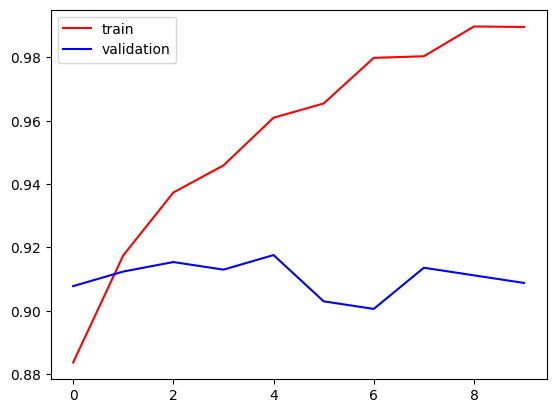

In [37]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

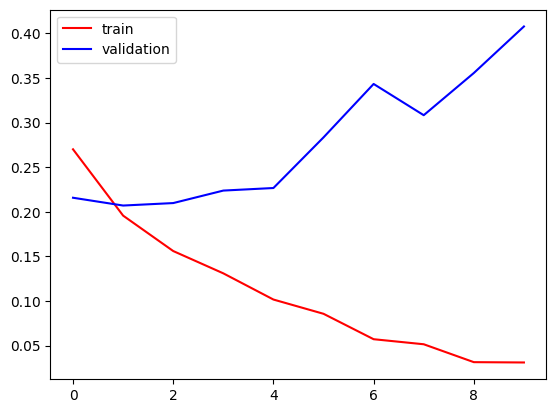

In [38]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

## **Data Augmentation**

In [40]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [41]:
train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [42]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [43]:
history = model.fit(train_generator, epochs = 10, validation_data = validation_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 175s 275ms/step - accuracy: 0.9147 - loss: 0.2211 - val_accuracy: 0.9116 - val_loss: 0.2387
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 192s 259ms/step - accuracy: 0.9229 - loss: 0.1825 - val_accuracy: 0.9174 - val_loss: 0.2063
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 161s 256ms/step - accuracy: 0.9304 - loss: 0.1691 - val_accuracy: 0.9102 - val_loss: 0.2202
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 161s 256ms/step - accuracy: 0.9335 - loss: 0.1665 - val_accuracy: 0.9144 - val_loss: 0.2275
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 164s 258ms/step - accuracy: 0.9398 - loss: 0.1439 - val_accuracy: 0.9178 - val_loss: 0.2030
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 162s 257ms/step - accuracy: 0.9407 - loss: 0.1419 - val_accuracy: 0.9228 - val_loss: 0.2145
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 259ms/step - accuracy: 0.9468 - loss: 0.1344 - val_accuracy: 0.9190 - val_loss: 0.2214
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 201s 256ms/step - accuracy: 0.9493 - loss: 0.12

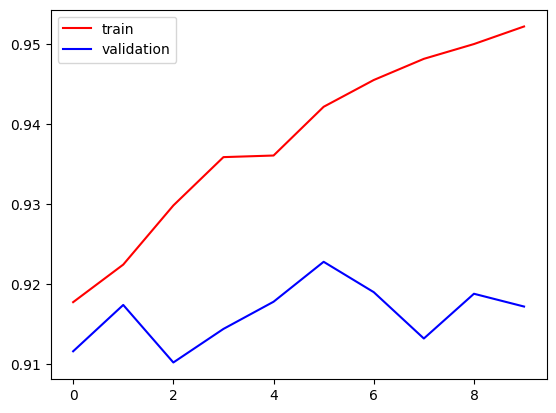

In [44]:
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

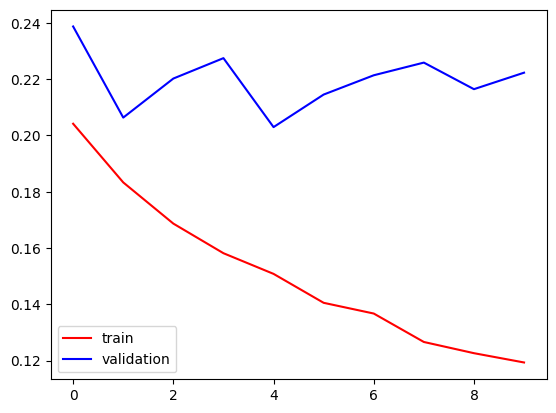

In [45]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()